compared to the 8k version, the results look more promising --- there are some wins and loses between goal-driven (transfer learning) and data-driven. Still, the result is much less significant visually, compared to what I have in the thesis proposal.

In [1]:
from sys import path
from os.path import join

from thesis_v2 import dir_dict

folder_to_check = 'scripts/training/crcns_pvc8_large'
path.insert(0, join(dir_dict['root'], folder_to_check))
from transfer_learning_factorized_vgg.submit import sparse_list
from transfer_learning_factorized_vgg.key_utils import keygen as keygen_vgg
from maskcnn_polished.key_utils import keygen as keygen_maskcnn

In [2]:
# now let's load vgg's best ones, one for 50x50, one for 100x100.

from thesis_v2.training_extra.transfer_learning.analysis import collect_one_setting

def load_vgg_result(param):
    # vgg11_bn's conv3_1 seems to be the best for 100x100.
    # vgg11_bn's conv2_1 seems to be the best for 50x50.
    # probably this is due to input scaling issue.
    return collect_one_setting(
        sparse_list=sparse_list,
        keygen=keygen_vgg,
        param=param,
    )

vgg_result_template = {
    'suffix': 'vgg11/half/3.0',
    'split_seed': 0,
    'model_seed': 0,
    'act_fn': 'relu',
    'loss_type': 'poisson',
}

vgg_best_legacy = load_vgg_result(
{
    **vgg_result_template,
    'shuffle_type': 'legacy',
}
)['test_best']

# by using this one (rather than mse + relu, which performed best for legacy), we can use same setup for both results.

vgg_best_paired = load_vgg_result(
{
    **vgg_result_template,
    'shuffle_type': 'paired',
}
)['test_best']

In [3]:
vgg_best_legacy.mean(), vgg_best_paired.mean()
# match those in the ipynb notebook (`vgg.ipynb`).

(0.6894868067868699, 0.637808130472494)

In [4]:
# now let's load maskcnn_polished's best ones, one for 50x50, one for 100x100.

In [5]:
from thesis_v2.training.training_aux import load_training_results
import numpy as np
def load_maskcnn_result(param):
    results = [
        load_maskcnn_result_inner(
            {
                **param,
                **{
                     'model_seed': x,
                }
            }
        ) for x in range(3)
    ]
    results = np.asarray(results)
    print(results.shape)
    return results.mean(axis=0)

def load_maskcnn_result_inner(param):
    # this is tricky, because I did not save per neuron corr during training.
    # shit.
    #
    # afterwards, I will simply save thoese perneuron corr.
    # 
    # right now, let's load the data set and do the evaluation again.
    assert param['out_channel'] == 16
    assert param['num_layer'] == 2
    assert param['kernel_size_l1'] == 7
    assert param['pooling_ksize'] == 3
    assert param['pooling_type'] == 'avg'

    key = keygen_maskcnn(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
    result = load_training_results(key, return_model=False)['stats_best']['stats']['test']['corr']
    result = np.asarray(result)
    return result
    

maskcnn_param_template = {
    'out_channel': 16,
    'num_layer': 2,
    'kernel_size_l1': 7,
    'pooling_ksize': 3,
    'pooling_type': 'avg',
    'split_seed': 0,
    
    'act_fn': 'relu',
    'bn_before_act': True,
    'loss_type': 'mse',
    'smoothness_name': '0.00002',
    'scale_name': '0.01105',
    'bn_after_fc': False,
    
}
maskcnn_best_legacy = load_maskcnn_result(
    # 0.537495 in `basic.ipynb`.
    {
        **maskcnn_param_template,
        'shuffle_type': 'legacy',
    }
)

maskcnn_best_paired = load_maskcnn_result(
    # 0.537495 in `basic.ipynb`.
    {
        **maskcnn_param_template,
        'shuffle_type': 'paired',
    }
)

(3, 221)
(3, 221)


In [6]:
maskcnn_best_legacy.mean(), maskcnn_best_paired.mean()

(0.7291439185944438, 0.6951750037941639)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(12, 10))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print(xlabel, x.mean(), ylabel, y.mean())
    print('corr', pearsonr(x, y)[0])

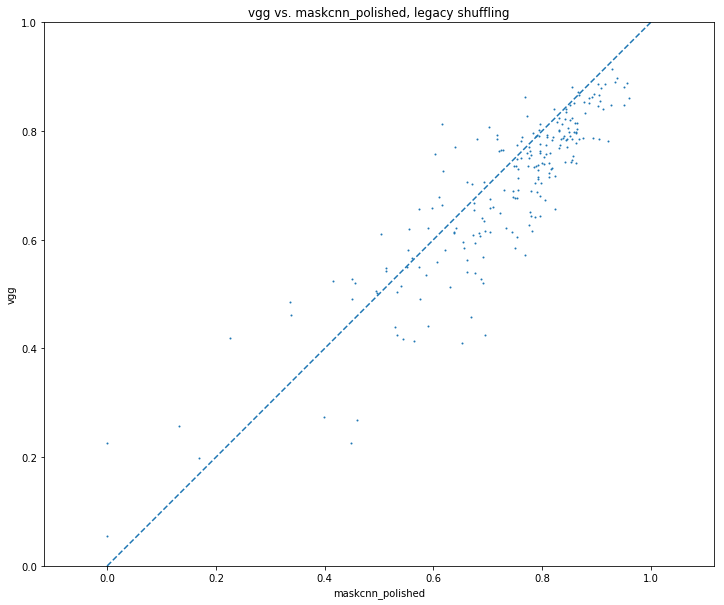

maskcnn_polished 0.7291439185944438 vgg 0.6894868067868699
corr 0.8876809616167651


In [8]:
scatter(maskcnn_best_legacy, vgg_best_legacy, 'maskcnn_polished', 'vgg', 'vgg vs. maskcnn_polished, legacy shuffling')

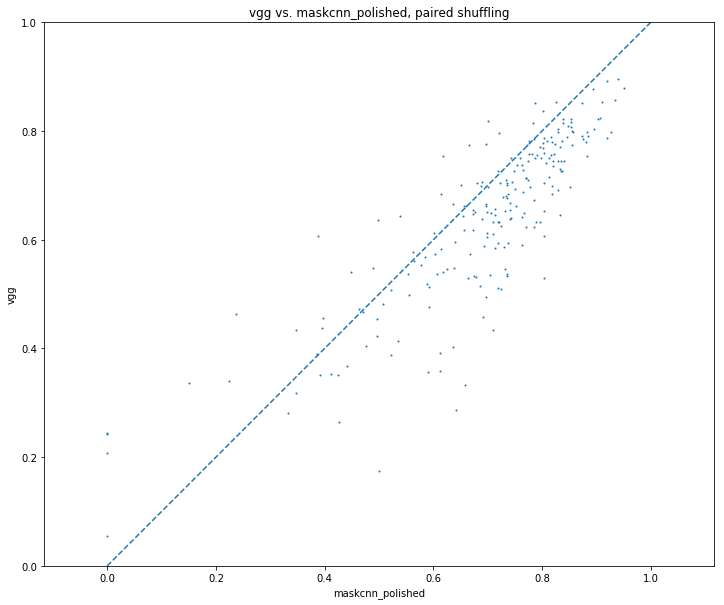

maskcnn_polished 0.6951750037941639 vgg 0.637808130472494
corr 0.8430016391220836


In [9]:
scatter(maskcnn_best_paired, vgg_best_paired, 'maskcnn_polished', 'vgg', 'vgg vs. maskcnn_polished, paired shuffling')